# Reconhecimento de Espécies Vegetais Amazônicas por Meio de Redes Neurais Convolucionais

## Preparação do ambiente

### Instala as bibliotecas necessárias para o projeto

In [1]:
! pip install patchify

### Carrega as bibliotecas necessárias para o projeto

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive, output

import zipfile
import tarfile
import os
import shutil
import time
import string

import cv2

import patchify


warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


### Verifica as versões das aplicações instaladas

In [ ]:
print(f'Versão TensorFlow: {tf.__version__}')
print(f'Versão Keras: {keras.__version__}')
print(f'Versão Scikit-Learn: {sklearn.__version__}')
print(f'Versão Numpy: {np.__version__}')
print(f'Versão Pandas: {pd.__version__}')
print(f'Versão Matplotlib: {sns.__version__}')
print(f'Versão Seaborn: {sns.__version__}')
print(f'Versão CV2: {cv2.__version__}')

Versão TensorFlow: 2.18.0
Versão Keras: 3.8.0
Versão Scikit-Learn: 1.6.1
Versão Numpy: 1.26.4
Versão Pandas: 2.2.2
Versão Matplotlib: 0.13.2
Versão Seaborn: 0.13.2
Versão CV2: 4.11.0


### Carrega a base de imagens

In [ ]:
def upload_patches():
  from google.colab import output

  # Download arquivo zip 1
  ! gdown 1RajkAeTumEVBAbrq3BIVj8ELFm2USifw

  # Download arquivo zip 2
  ! gdown 1Sg0ZuRN5vRASb13mp5JVSkvRLeko_Mp8

  # Download arquivo zip 3
  ! gdown 1iPHhbOb7X8dc9c0PLj1uaw5PEmAUVrGh

  # Download arquivo zip 4
  ! gdown 1SHCsgrARnZIEZ43gauQf-8ycsk9OV3xy

  # Download arquivo zip 5
  ! gdown 18PW2ac7hGe494TAkGzg3IGEntktT6f9Q

  # Download arquivo zip 6
  ! gdown 1M9qKLrQ-Z98FTTW9Jo2xcpwjwSfHj3WN

  # Download arquivo zip 7
  ! gdown 1vGa8kdjsTlYQgM7mJzpteoKNE5IsGsz5

  output.clear()
  print('\n Arquivos baixados com sucesso !')


def uncompress_patches():
  import os

  for files in os.listdir('/content'):
    if files.endswith('.zip'):
      ! unzip $files
      ! rm $files
  output.clear()
  print(f'\n Arquivos descompactados com sucesso !')


upload_patches()
uncompress_patches()


 Arquivos descompactados com sucesso !


## Obtenção da base de dados

### Biblioteca de funções para *criação de estrutura de diretórios*. *movimentação de arquivos*, *verificação da integridade de arquivos zip e tar.gz* e *descompactação de arquivos zip e tar.gz em uma estrutura de diretórios*

In [ ]:
class Cria_Dataset:
  def __init__(self, caminho_do_projeto_no_google_drive, numero_de_classes):
    self.path_origem = caminho_do_projeto_no_google_drive
    self.compressed_folder = os.path.join(self.path_origem, 'Compressed')
    self.images_folder = os.path.join(self.path_origem, 'Images', 'original_size')
    self.temp_images_folder = os.path.join(self.path_origem, 'Images', 'Temp')
    self.num_classes = numero_de_classes


  def cria_estrutura_dir_imagens(self):
    '''
    Cria estrutura de diretório do tipo:

      Projeto
      |--- Images
      |----- original_size
      |------- class_1
      |------- class_2
      ...
      |------- class n
    '''

    # Verifica se os diretorios existem e cria apenas se não existirem
    for dir_num in range(self.num_classes):
      nome_dir_classe = 'class_' + str(dir_num + 1)
      dir_nome = os.path.join(self.images_folder, nome_dir_classe)
       # Verifica se os diretorios existem e cria apenas se não existirem
      if not os.path.exists(dir_nome):
        os.makedirs(dir_nome, exist_ok = True)
        print(f'O diretório {nome_dir_classe} foi criado')



  def move_imagens_temp_class(self):
    '''
      Move os arquivos de imagens
      de
        /Projeto/Images/Temp

      para
        /Projeto/Images/original_size/Class_1
        /Projeto/Images/original_size/Class_2
        ...
        /Projeto/Images/original_size/Class_41
    '''
    path_origem = self.temp_images_folder

    # Gera automaticamente o dicionário de prefixos para classes
    prefix_to_class = {f"{i:02}": f"class_{i}" for i in range(1, self.num_classes + 1)}

    # Executa função de criação da estrutura de pastas
    self.cria_estrutura_dir_imagens()

    for arquivo in os.listdir(path_origem):
      origem = os.path.join(path_origem, arquivo)
      # Verifica se é um arquivo (ignorar diretórios)
      if not os.path.isfile(origem):
        continue
      # Identifica a classe baseada no prefixo
      for prefixo, pasta in prefix_to_class.items():
        if arquivo.startswith(prefixo):
          destino = os.path.join(self.images_folder, pasta, arquivo)
          shutil.move(origem, destino)
    print('\nTodos os arquivos foram movidos com sucesso !')




  def faz_download(self, url_sem_arquivo, arquivo_para_baixar):

    '''
        Objetivo:
          Realizar o download de arquivos de um site ou servidor.

        Uso:
        Devem ser fornecidos:
          1. url_sem_arquivo: url sem o nome do arquivo a ser baixado.
             Exemplo:
                url_sem_arquivo = 'https://zenodo.org/record/10219797/files/'

          2. arquivo_para_baixar: lista com os nomes dos arquivos a serem baixados.
             Exemplo:
                arquivo_para_baixar = ['macroscopic0.zip', 'macroscopic1.tar.gz',
                                       'macroscopic2.tar.gz', 'macroscopic3.tar.gz',
                                       'macroscopic4.tar.gz']
    '''

    import requests
    import tqdm
    import shutil
    import os

    # Renomeia o diretório Compressed se já existir
    if os.path.exists(self.compressed_folder):
      timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
      novo_dir = self.compressed_folder + f"_backup_{timestamp}"
      shutil.move(self.compressed_folder, novo_dir)
      print(f"Diretório 'Compressed' existente foi renomeado para: {novo_dir}")

    # Criação do diretório \Compressed
    os.makedirs(self.compressed_folder, exist_ok=True)

    # Faz o download dos arquivos
    for arquivo in arquivo_para_baixar:
      url = url_sem_arquivo + arquivo
      destino = os.path.join(self.compressed_folder, arquivo)

      try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Verifica se o download foi bem-sucedido

        total_size = int(response.headers.get('content-length', 0))  # Obtém o tamanho total do arquivo
        block_size = 1024  # Define o tamanho do bloco de leitura
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc=arquivo)

        with open(destino, 'wb') as file:
          for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
            progress_bar.close()
            print(f'Download do arquivo {arquivo} finalizado.\n')

      except requests.exceptions.RequestException as e:
            print(f'Erro ao baixar o arquivo {arquivo}: {e}')

    print('Todos os arquivos baixados com sucesso !')



  def verifica_arquivos_zip(self, arquivo_zip):
    '''
      Objetivo:
      Verifica o número de arquivos compactados em um arquivo zip.

      Uso:
      Deve ser informado o nome do arquivo zip a ser descompactado.
      Exemplo:
        arquivo_zip = 'macroscopic0.zip'
    '''
    arquivo_zip_full_path = os.path.join(self.compressed_folder, arquivo_zip)

    # Verifica quantos arquivos estão no arquivo .zip
    with zipfile.ZipFile(arquivo_zip_full_path, 'r') as zip_ref:
      file_list = zip_ref.namelist()
      zip_num_files = len(file_list)
    return zip_num_files


  def verifica_arquivos_tar(self, arquivo_tar):
    '''
      Objetivo:
      Verifica o número de arquivos compactados em um arquivo tar.gz.

      Uso:
      Deve ser informado o nome do arquivo tar.gz a ser descompactado.
      Exemplo:
        arquivo_tar = 'macroscopic1.tar.gz'
    '''
    arquivo_tar_full_path = os.path.join(self.compressed_folder, arquivo_tar)

    # Verifica quantos arquivos estão no arquivo .tar.gz
    with tarfile.open(arquivo_tar_full_path, 'r:gz') as tar_ref:
        file_list = tar_ref.getnames()  # Lista os arquivos dentro do tar.gz
        tar_num_files = len(file_list)
    return tar_num_files



  def extrai_arquivos_zip(self, arquivo_zip):
    '''
      Objetivo:
      Descompacta um arquivo zip.

      Uso:
      Deve ser informado o nome do arquivo zip a ser descompactado.
      Exemplo:
        arquivo_zip = 'macroscopic0.zip'
    '''
    arquivo_zip_full_path = os.path.join(self.compressed_folder, arquivo_zip)

    # Remove a pasta temporária
    if os.path.exists(self.temp_images_folder):
      shutil.rmtree(self.temp_images_folder)

    # Cria a pasta temporária novamente
    os.makedirs(self.temp_images_folder, exist_ok=True)

    # Extrai as imagens do arquivo zip para uma pasta temporária
    print('\nDescompactando as imagens')
    with zipfile.ZipFile(arquivo_zip_full_path, 'r') as zip_ref:
      zip_ref.extractall(self.temp_images_folder)

    # Conta o número de imagens extraídas
    arquivos_extraidos = os.listdir(self.temp_images_folder)
    num_arquivos_extraidos = len(arquivos_extraidos)

    # Verifica o número de imagens no arquivo zip
    zip_num_files = self.verifica_arquivos_zip(arquivo_zip)

    # Compara o número de imagens no arquivo zip com o número de imagens extraídas
    if num_arquivos_extraidos == zip_num_files:
      print(f'O arquivo {arquivo_zip} foi descompactado com sucesso !\n')

      # Move as imagens para o diretorio definitivo
      self.move_imagens_temp_class()
    else:
      print(f'\nO arquivo {arquivo_zip} não foi descompactado corretamente')



  def extrai_arquivos_tar(self, arquivo_tar):
    '''
      Objetivo:
      Descompacta um arquivo tar.gz.

      Uso:
      Deve ser informado o nome do arquivo tar.gz a ser descompactado.
      Exemplo:
        arquivo_tar = 'macroscopic1.tar.gz'
    '''
    arquivo_tar_full_path = os.path.join(self.compressed_folder, arquivo_tar)

    # Remove a pasta temporária
    if os.path.exists(self.temp_images_folder):
      shutil.rmtree(self.temp_images_folder)

    # Cria a pasta temporária novamente
    os.makedirs(self.temp_images_folder, exist_ok=True)

    # Extrai as imagens do arquivo tar.gz para uma pasta temporária
    print('\nDescompactando as imagens')
    with tarfile.open(arquivo_tar_full_path, 'r:gz') as tar_ref:
        tar_ref.extractall(self.temp_images_folder)

    # Conta o número de imagens extraídas
    arquivos_extraidos = os.listdir(self.temp_images_folder)
    num_arquivos_extraidos = len(arquivos_extraidos)

    # Verifica o número de imagens no arquivo zip
    tar_num_files = self.verifica_arquivos_tar(arquivo_tar)

    # Compara o número de imagens no arquivo tar.gz com o número de imagens extraídas
    if num_arquivos_extraidos == tar_num_files:
      print(f'\nO arquivo {arquivo_tar} foi descompactado com sucesso !\n')

      # Apaga todos os arquivos que se iniciam por ._
      for arquivo in os.listdir(self.temp_images_folder):
        if arquivo.startswith('.'):
          file_path = os.path.join(self.temp_images_folder, arquivo)
          os.remove(file_path)

      # Move as imagens para o diretorio definitivo
      self.move_imagens_temp_class()
    else:
      print(f'\nO arquivo {arquivo_tar} não foi descompactado corretamente')


#### Faz o download dos arquivos, cria a estrutura de pastas e organiza as imagens

In [ ]:
caminho_do_projeto_no_google_drive = '/content/drive/MyDrive/USP/TCC/Application/Dataset'
url = 'https://zenodo.org/record/10219797/files/'
classes = 41
arquivos = ['macroscopic0.zip', 'macroscopic1.tar.gz', 'macroscopic2.tar.gz',
            'macroscopic3.tar.gz', 'macroscopic4.tar.gz']

dataset = Cria_Dataset(caminho_do_projeto_no_google_drive, classes)
dataset.faz_download(url, arquivos)
dataset.extrai_arquivos_zip(arquivos[0])
for arquivos in arquivos[1:]:
  dataset.extrai_arquivos_tar(arquivos)

## Análise Exploratória de Dados

### Exibe duas imagens de cada classe

In [ ]:
# Define onde as imagens originais estão armazenadas
original_images = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'

# Percorre as pastas de cada uma das classes
for pasta in os.listdir(original_images):
  caminho = os.path.join(original_images, pasta)
  # Verifica quantas imagens cada uma das classes possui
  qtd_imagens = len(os.listdir(caminho))
  # Mostra 2 imagens de cada classe
  for i in range(2):
    # Sorteia uma imagem do intervalo 0 até o número total de imagens da classe
    img_num = np.random.randint(0, qtd_imagens)
    imagem = os.listdir(caminho)[img_num]
    plt.figure(figsize=(3, 3))
    img = cv2.imread(os.path.join(caminho, imagem))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagem {imagem}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Verifica propriedades de uma imagem aleatória

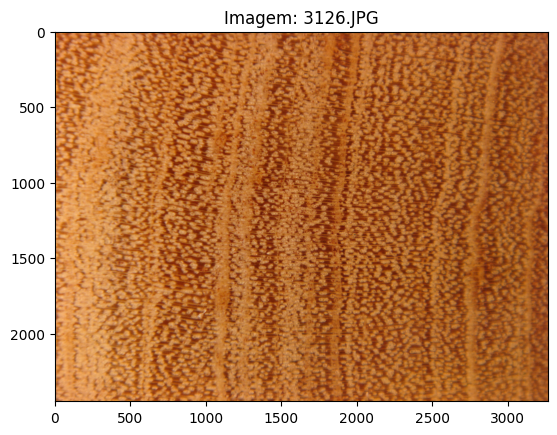


O formato da imagem é: (2448, 3264, 3)
A resolução da imagem é de 23970816 pixels


In [ ]:
original_images = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'

class_num = np.random.randint(1, 42)
image_num = np.random.randint(0,37)

caminho = os.path.join(original_images, f'class_{class_num}')
imagem = os.listdir(caminho)[image_num]

img = cv2.imread(os.path.join(caminho, imagem))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'Imagem: {imagem}')
plt.show()
img_shape = img.shape
print(f'\nO formato da imagem é: {img_shape}')
img_res = img.size
print(f'A resolução da imagem é de {img_res} pixels')

### Verifica o total de imagens

In [ ]:
original_images = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'

total_imagens = 0
for i in range(1, 42):
  caminho = os.path.join(original_images, f'class_{i}')
  qtd_imagens = len(os.listdir(caminho))
  total_imagens += qtd_imagens
print(f'A base possui um total de {total_imagens} imagens.')

A base possui um total de 2942 imagens.


### Verifica o número de imagens por classe

In [ ]:
original_images = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'
imagem_base_original = [[1, 53], [2, 63], [3, 43], [4, 99], [5, 63],
 [6, 41], [7, 48], [8, 75], [9, 72], [10, 98], [11, 37], [12, 99], [13, 56],
 [14, 67], [15, 51], [16, 78], [17, 99], [18, 53], [19, 94], [20, 86], [21, 99],
 [22, 99], [23, 64], [24, 82], [25, 55], [26, 46], [27, 87], [28, 92], [29, 96],
 [30, 51], [31, 96], [32, 99], [33, 43], [34, 79], [35, 62], [36, 59], [37, 58],
 [38, 99], [39, 58], [40, 63], [41, 80]]

imagens = {}
for i in range(1, len(os.listdir(original_images)) + 1):
  caminho = os.path.join(original_images, f'class_{i}')
  qtd_imagens = len(os.listdir(caminho))
  imagens[i] = {'class': i, 'qtd': qtd_imagens}

  if imagem_base_original[i-1][1] == qtd_imagens:
   print(f'A classe {i} possui {qtd_imagens} imagens e está COMPLETA')
  elif imagem_base_original[i-1][1] != qtd_imagens:
   print('FALTAM IMAGENS NA BASE')


A classe 1 possui 53 imagens e está COMPLETA
A classe 2 possui 63 imagens e está COMPLETA
A classe 3 possui 43 imagens e está COMPLETA
A classe 4 possui 99 imagens e está COMPLETA
A classe 5 possui 63 imagens e está COMPLETA
A classe 6 possui 41 imagens e está COMPLETA
A classe 7 possui 48 imagens e está COMPLETA
A classe 8 possui 75 imagens e está COMPLETA
A classe 9 possui 72 imagens e está COMPLETA
A classe 10 possui 98 imagens e está COMPLETA
A classe 11 possui 37 imagens e está COMPLETA
A classe 12 possui 99 imagens e está COMPLETA
A classe 13 possui 56 imagens e está COMPLETA
A classe 14 possui 67 imagens e está COMPLETA
A classe 15 possui 51 imagens e está COMPLETA
A classe 16 possui 78 imagens e está COMPLETA
A classe 17 possui 99 imagens e está COMPLETA
A classe 18 possui 53 imagens e está COMPLETA
A classe 19 possui 94 imagens e está COMPLETA
A classe 20 possui 86 imagens e está COMPLETA
A classe 21 possui 99 imagens e está COMPLETA
A classe 22 possui 99 imagens e está COMPLE

In [ ]:
patches = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/patches'
imagem_base_original = [[1, 53], [2, 63], [3, 43], [4, 99], [5, 63],
 [6, 41], [7, 48], [8, 75], [9, 72], [10, 98], [11, 37], [12, 99], [13, 56],
 [14, 67], [15, 51], [16, 78], [17, 99], [18, 53], [19, 94], [20, 86], [21, 99],
 [22, 99], [23, 64], [24, 82], [25, 55], [26, 46], [27, 87], [28, 92], [29, 96],
 [30, 51], [31, 96], [32, 99], [33, 43], [34, 79], [35, 62], [36, 59], [37, 58],
 [38, 99], [39, 58], [40, 63], [41, 80]]

imagens = {}
total_img = 0
for i in range(1, len(os.listdir(patches)) + 1):
  caminho = os.path.join(patches, f'class_{i}')
  qtd_imagens = len(os.listdir(caminho))
  imagens[i] = {'class': i, 'qtd': qtd_imagens}
  total_img += qtd_imagens

  if (imagem_base_original[i-1][1] * 140) == qtd_imagens:
   print(f'A classe {i} possui {qtd_imagens} imagens e está COMPLETA')
  elif (imagem_base_original[i-1][1] * 140) != qtd_imagens:
   print(f'A CLASSE {i} ESTÁ INCOMPLETA')
print(f'A base possui um total de {total_img} patches.')

A classe 1 possui 7420 imagens e está COMPLETA
A classe 2 possui 8820 imagens e está COMPLETA
A classe 3 possui 6020 imagens e está COMPLETA
A classe 4 possui 13860 imagens e está COMPLETA
A classe 5 possui 8820 imagens e está COMPLETA
A classe 6 possui 5740 imagens e está COMPLETA
A classe 7 possui 6720 imagens e está COMPLETA
A classe 8 possui 10500 imagens e está COMPLETA
A CLASSE 9 ESTÁ INCOMPLETA
A classe 10 possui 13720 imagens e está COMPLETA
A classe 11 possui 5180 imagens e está COMPLETA
A classe 12 possui 13860 imagens e está COMPLETA
A classe 13 possui 7840 imagens e está COMPLETA
A classe 14 possui 9380 imagens e está COMPLETA
A classe 15 possui 7140 imagens e está COMPLETA
A classe 16 possui 10920 imagens e está COMPLETA
A classe 17 possui 13860 imagens e está COMPLETA
A classe 18 possui 7420 imagens e está COMPLETA
A classe 19 possui 13160 imagens e está COMPLETA
A classe 20 possui 12040 imagens e está COMPLETA
A classe 21 possui 13860 imagens e está COMPLETA
A classe 22 

### Cria gráfico de distribuição das imagens por classe

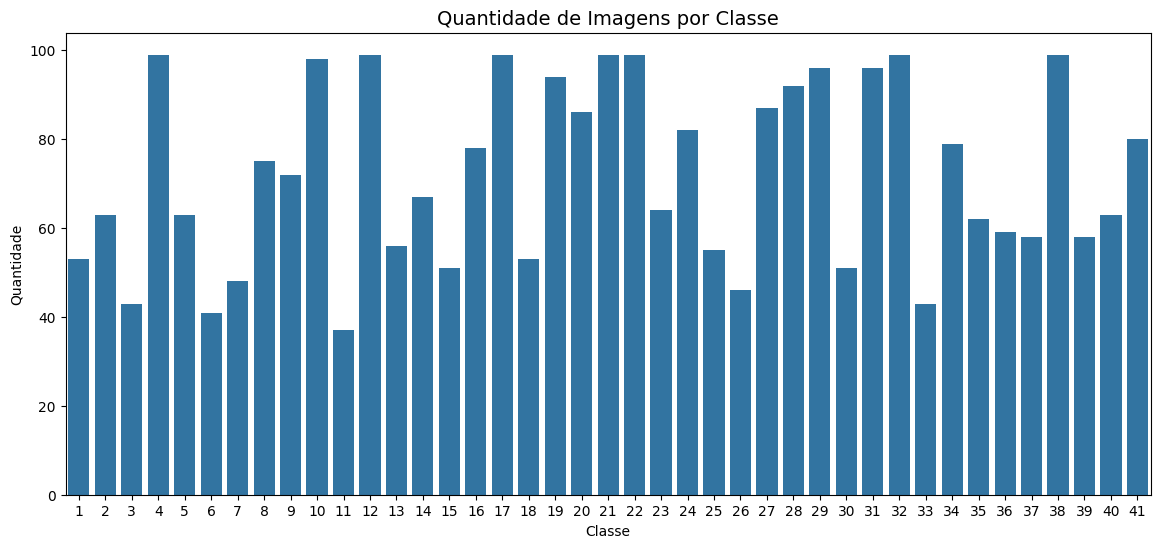

In [ ]:
imagens = {}
for i in range(1, 42):
  caminho = os.path.join(original_images, f'class_{i}')
  qtd_imagens = len(os.listdir(caminho))
  imagens[i] = {'class': i, 'qtd': qtd_imagens}

df_imagens = pd.DataFrame(imagens).T

plt.figure(figsize=(14, 6))
sns.barplot(x='class', y='qtd', data=df_imagens)
plt.title('Quantidade de Imagens por Classe', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

### Análise das imagens

**Diagnóstico**  
- O dataset possui 2942 imagens divididas de forma heterogênea por 41 espécies de madeira.  
- As classes encontra-se desbalanceadas, uma vez que o número de imagens em cada uma varia de 37 a 99.  
- As imagens possuem a mesma resolução, isto é, 2448x3264 pixels.  
- Todas as images são coloridas e utilizam o sistema de cores RGB.  

<br>

**Ações para mitigação dos problemas**  



---

<br>

## Pre-processamento  


### Função para divisão das imagens originais em patches

In [ ]:
def cria_patches(base_folder, patch_folder, patch_size):
  '''
    As dimensões dos patches dependem do modelo a ser utilizado.
    As imagens originais possuem dimensões de 3264x2448.
    Por exemplo:
      MobileNetV2 suporta imagens de 224x224.
      ResNet50 suporta imagens de até 256x256.
  '''
  # Inicializa a variável do contador de arquivos
  conta = 1

  # Verifica se a pasta de destino existe, se não existir cria (.../Images/train/patches/class_1)
  classes = sorted(os.listdir(base_folder))
  for classe in classes:
    class_full_path = os.path.join(base_folder, 'patches', classe)
    if not os.path.exists(class_full_path):
      os.makedirs(class_full_path, exist_ok=True)

  # Lista todos os diretórios de classes em Images/(train ou test ou val)
  for pasta in sorted(os.listdir(base_folder)):

    # Lista todos os arquivos dentro de cada classe
    for imagem in sorted(os.listdir(os.path.join(base_folder, pasta))):

      # Carregar a imagem como um np.array
      img = cv2.imread(os.path.join(base_folder, pasta, imagem))

      # Verifica se a imagem foi carregada corretamente
      if img is None:
        print(f'Erro! Não foi possível carregar a imagem: {os.path.join(base_folder, pasta, imagem)}')
        # Segue para a próxima imagem se a atual não puder ser carregada
        continue

      # Ajuste nas dimensões da imagem (de 3264px x 2448px para 3136px x 2352px) para
      # que não haja áreas sem cobertura de patches
      img = cv2.resize(img, (3136, 2240), interpolation=cv2.INTER_CUBIC)

      # Dividir a imagem em patches
      patches = patchify.patchify(img, (patch_size, patch_size, 3), step=patch_size)

      # Redimensiona o tensor para que ele tenha apenas 4 dimensões
      patches = patches.reshape(-1, 224, 224, 3)

      # Salvar os patches
      for i, patch in enumerate(patches):
        cv2.imwrite(os.path.join(patch_folder, pasta, f'{imagem[:-4]}_patch_{i}.jpg'), patch)
        print(f'Arquivo: {conta} / Pasta: {pasta} / Imagem: {imagem} / Patch: {i}')

        # Gravar a saída em um arquivo txt
        with open(os.path.join(log_path, 'log.txt'), 'a') as f:
          f.write(f'Arquivo: {conta} / Pasta: {pasta} / Imagem: {imagem} / Patch: {i}\n')
        conta += 1

  print('Todos os patches foram criados com sucesso !')


### FUNÇÃO PARA GERAÇÃO DE PATCHES INDIVIDUAIS

In [ ]:
def cria_patches(source_folder, dest_folder, patch_size, img_name):
  '''
    As dimensões dos patches dependem do modelo a ser utilizado.
    As imagens originais possuem dimensões de 3264x2448.
    Por exemplo:
      MobileNetV2 suporta imagens de 224x224.
      ResNet50 suporta imagens de até 256x256.
  '''

  img = cv2.imread(os.path.join(source_folder, img_name))
  # Verifica se a imagem foi carregada corretamente
  if img is None:
    print(f'Erro! Não foi possível carregar a imagem: {img_name}')


  # Ajuste nas dimensões da imagem (de 3264px x 2448px para 3136px x 2352px) para
  # que não haja áreas sem cobertura de patches
  img = cv2.resize(img, (3136, 2240), interpolation=cv2.INTER_CUBIC)

  # Dividir a imagem em patches
  patches = patchify.patchify(img, (patch_size, patch_size, 3), step=patch_size)

  # Redimensiona o tensor para que ele tenha apenas 4 dimensões
  patches = patches.reshape(-1, 224, 224, 3)

  # Salvar os patches
  for i, patch in enumerate(patches):
    cv2.imwrite(os.path.join(dest_folder, f'{img_name[:-4]}_patch_{i}.jpg'), patch)
    print(f'Arquivo {img_name[:-4]}_patch_{i}.jpg gerado')

  print('Todos os patches foram criados com sucesso !')



source_folder = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size/class_9'
dest_folder = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/patches/class_9'
patch_size = 224
img_name = '0972.JPG'

cria_patches(source_folder, dest_folder, patch_size, img_name)

#### Geração dos patches

In [ ]:
base_folder = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'
patch_folder = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/patches'
log_path = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images'
patch_size = 224

cria_patches(base_folder, patch_folder, patch_size)

### Função para criação das bases de treinamento, teste e validação

In [ ]:
def create_train_test_val_datasets(image_path, test_size, val_size):
  '''
    Objetivo:
    Esta função cria um dataset a partir das imagens originais (sem patches).
    Neste dataset temos:
      - Nome da imagem
      - Pasta da imagem (classe_xx)
      - Caminho da imagem
      - Classe a qual a imagem pertence (classe_xx)

    Descrição:
    1. Criação do dataset a partir das imagens originais cntendo as colunas acimma.
    2. Uma vez criado o dataset, é feita a divisão entre base de trinamento e teste,
    que é executada utilizando a técnica de amostragem estratificada e que leva em
    conta a heterogeneidade de dados entre as classes.
    3. A partir da base de treinamento é feita uma nova divisão para a criação da
    base de validação.
    4. Ao final tem-se as seguintes matrizes:
      - X_train_original: base de treinamento
      - X_test_original: base de teste
      - X_val_original: base de validação
      - y_train_original: classes da base de treinamento
      - y_test_original: classes da base de teste
      - y_val_original: classes da base de validação

  '''

  dados = []

  for pasta in os.listdir(image_path):
    caminho = os.path.join(image_path, pasta)
    if pasta.startswith('class_'):
      classe_num = pasta.split('_')[1]
      for imagem in os.listdir(os.path.join(image_path, pasta)):
        dados.append([imagem, pasta, caminho, int(classe_num)])

  dados = pd.DataFrame(dados, columns=['Imagem', 'Pasta', 'Caminho', 'Classe'])

  X = dados[['Imagem', 'Pasta', 'Caminho']]
  y = dados['Classe']

  X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X,
                                                                                          y,
                                                                                          test_size=test_size,
                                                                                          random_state=42,
                                                                                          stratify=y)

  X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(X_train_original,
                                                                                        y_train_original,
                                                                                        test_size=val_size,
                                                                                        random_state=42,
                                                                                        stratify=y_train_original)

  return X_train_original, X_test_original, X_val_original, y_train_original, y_test_original, y_val_original

#### Criação das bases de treinamento, teste e validação

In [ ]:
image_path = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images/original_size'

# Base de teste com 20% das amostras
test_size = 0.2

# Base de validação com 10% das amostras
val_size = 0.1

X_train_original, X_test_original, X_val_original, y_train_original, y_test_original, y_val_original = create_train_test_val_datasets(image_path, test_size, val_size)

In [ ]:
def cria_lista_final(imagens, labels, caminho_patch):
  '''
    Objetivo:
      Esta função faz o mapeamento de cada patch com a respectiva imagem original.

    Parâmetros:
      imagens: deve ser informado X_train_original ou X_test_original ou
                 X_val_original.
      labels: deve ser informado y_train_original ou y_test_original ou
              y_val_original.
      caminho_patch: deve ser informado o caminho onde estão os patches.

    OBSERVAÇÂO IMPORTANTE:
      Antes de executar esta função é necessário executar a função cria_patches.
  '''
  X, y = [], []
  registros_df = imagens.shape[0]

  # Percorre todos os registros de X_train, X_test ou X_val
  for i in range(registros_df):
    # Recupera o nome da imagem
    imagem =  X_train_original.iloc[i, 0]
    # Recupera a classe da imagem
    pasta = X_train_original.iloc[i, 1]
    # O loop representa os 140 patches (0 a 139)
    for patch_num in range(140):
      # Formata o nome do patch
      patch = imagem[:-4] + '_patch_' + str(patch_num) + '.jpg'
      # Formata o caminho físico da imagem do patch
      caminho = os.path.join(caminho_patch, pasta, patch)
      # Formata o número da classe
      classe = int(pasta.split('_')[1])
      # Armazena o conteúdo em uma lista
      X.append([imagem, pasta, patch, patch_num, caminho])
      y.append(classe)

  # Transforma a lista em um array NumPy
  X = np.array(X)
  # Transforma o array em um dataframe
  X = pd.DataFrame(X, columns=['Imagem', 'Pasta', 'Patch', 'Patch_num', 'Caminho'])

  return X, y


In [ ]:
caminho_patch = '/content/patches'

X_train, y_train = cria_lista_final(X_train_original, y_train_original, caminho_patch)
X_test, y_test = cria_lista_final(X_test_original, y_test_original, caminho_patch)
X_val, y_val = cria_lista_final(X_val_original, y_val_original, caminho_patch)

---  

<br>

## Modelagem

### Carregar as imagens

In [ ]:
X_train

,Imagem,Pasta,Patch,Patch_num,Caminho
0,1624.JPG,class_16,1624_patch_0.jpg,0,/content/patches/class_16/1624_patch_0.jpg
1,1624.JPG,class_16,1624_patch_1.jpg,1,/content/patches/class_16/1624_patch_1.jpg
2,1624.JPG,class_16,1624_patch_2.jpg,2,/content/patches/class_16/1624_patch_2.jpg
3,1624.JPG,class_16,1624_patch_3.jpg,3,/content/patches/class_16/1624_patch_3.jpg
4,1624.JPG,class_16,1624_patch_4.jpg,4,/content/patches/class_16/1624_patch_4.jpg
...,...,...,...,...,...
296375,3632.JPG,class_36,3632_patch_135.jpg,135,/content/patches/class_36/3632_patch_135.jpg
296376,3632.JPG,class_36,3632_patch_136.jpg,136,/content/patches/class_36/3632_patch_136.jpg
296377,3632.JPG,class_36,3632_patch_137.jpg,137,/content/patches/class_36/3632_patch_137.jpg
296378,3632.JPG,class_36,3632_patch_138.jpg,138,/content/patches/class_36/3632_patch_138.jpg


In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = max(y_train) + 1  # Get number of classes
y_train = to_categorical(y_train, num_classes=num_classes)

In [ ]:
# Convert image paths and labels to TensorFlow tensors
image_paths = tf.convert_to_tensor(X_train['Caminho'].tolist(), dtype=tf.string)
labels = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Ensure float for categorical

def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)  # Read image
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
    image = tf.image.resize(image, (224, 224))  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

BATCH_SIZE = 32

# Create dataset from file paths
X_train_final = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Apply preprocessing function
X_train_final = X_train_final.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch for performance
X_train_final = X_train_final.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
y_train_final = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = max(y_val) + 1  # Get number of classes
y_val = to_categorical(y_val, num_classes=num_classes)

In [ ]:
# Convert image paths and labels to TensorFlow tensors
image_paths = tf.convert_to_tensor(X_val['Caminho'].tolist(), dtype=tf.string)
labels = tf.convert_to_tensor(y_val, dtype=tf.float32)  # Ensure float for categorical

def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)  # Read image
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
    image = tf.image.resize(image, (224, 224))  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

BATCH_SIZE = 32

# Create dataset from file paths
X_val_final = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Apply preprocessing function
X_val_final = X_val_final.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch for performance
X_val_final = X_val_final.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
y_val_final = tf.convert_to_tensor(y_val, dtype=tf.float32)

### Separando em treino, teste e validação

In [ ]:
dataset_path = "/content/patches"
batch_size = 32
IMG_SIZE = (224, 224)

train_images = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% dos dados para validação
    subset="training",
    labels = 'inferred',
    label_mode='categorical',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    labels = 'inferred',
    label_mode='categorical',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)

# Splitting the validation dataset to create a test set
val_batches = tf.data.experimental.cardinality(val_images)
test_dataset = val_images.take(val_batches // 2)  # 50% of validation as test
val_dataset = val_images.skip(val_batches // 2)   # Remaining for validation

# Check class names
class_names = train_images.class_names
print("Classes:", class_names)

# Apply normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply it to the dataset
train_images_norm = train_images.map(lambda x, y: (normalization_layer(x), y))
val_images_norm = val_images.map(lambda x, y: (normalization_layer(x), y))
test_images_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 411764 files belonging to 41 classes.
Using 329412 files for training.
Found 411764 files belonging to 41 classes.
Using 82352 files for validation.
Classes: ['class_1', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14', 'class_15', 'class_16', 'class_17', 'class_18', 'class_19', 'class_2', 'class_20', 'class_21', 'class_22', 'class_23', 'class_24', 'class_25', 'class_26', 'class_27', 'class_28', 'class_29', 'class_3', 'class_30', 'class_31', 'class_32', 'class_33', 'class_34', 'class_35', 'class_36', 'class_37', 'class_38', 'class_39', 'class_4', 'class_40', 'class_41', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


### Tratamento do desbalanceamento de classes

In [ ]:
import os
import numpy as np

dataset_path = "/content/patches"
class_counts = {}

# Count images in each class
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print("Class Counts:", class_counts)

# Compute class weights
total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    i: total_samples / (num_classes * class_counts[class_name])
    for i, class_name in enumerate(class_counts.keys())
}

print("Class Weights:", class_weights)


Class Counts: {'class_25': 7700, 'class_22': 13860, 'class_31': 13440, 'class_35': 8680, 'class_4': 13860, 'class_39': 8120, 'class_21': 13860, 'class_24': 11480, 'class_6': 5740, 'class_1': 7420, 'class_11': 5180, 'class_36': 8260, 'class_20': 12040, 'class_33': 6020, 'class_32': 13860, 'class_29': 13440, 'class_3': 6020, 'class_37': 8120, 'class_9': 9964, 'class_18': 7420, 'class_28': 12880, 'class_14': 9380, 'class_41': 11200, 'class_12': 13860, 'class_17': 13860, 'class_16': 10920, 'class_8': 10500, 'class_38': 13860, 'class_26': 6440, 'class_34': 11060, 'class_7': 6720, 'class_27': 12180, 'class_5': 8820, 'class_40': 8820, 'class_23': 8960, 'class_15': 7140, 'class_2': 8820, 'class_10': 13720, 'class_30': 7140, 'class_13': 7840, 'class_19': 13160}
Class Weights: {0: 1.3042888818498575, 1: 0.7246049343610319, 2: 0.7472488385598142, 3: 1.1570304597055188, 4: 0.7246049343610319, 5: 1.2368256638231407, 6: 0.7246049343610319, 7: 0.8748279085578312, 8: 1.7496558171156624, 9: 1.353507330

### Criação do modelo de CNN

In [ ]:
def cria_modelo():

  # Carrega bibliotecas
  import tensorflow as tf
  from tensorflow import keras
  from keras.applications import MobileNetV2
  from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
  from keras.models import Model

  # Carrega o modelo MobileNetV2 removendo as camadas densas
  base_model = MobileNetV2(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3))

  # Unfreeze the last few layers for fine-tuning
  for layer in base_model.layers[-20:]:
        layer.trainable = True

  x = base_model.output
  x = GlobalAveragePooling2D()(x)  # Replace Flatten with GlobalAveragePooling2D
  x = Dense(512, activation="relu")(x)  # Increase neurons
  x = Dropout(0.5)(x)  # Increase dropout
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.4)(x)

  # Camada de saída com 41 neurônios, isto é, um para cada espécie de madeira
  classifier = Dense(41, activation="softmax")(x)

  modelo1 = Model(inputs=base_model.inputs, outputs=classifier)

  modelo1.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy"])

  modelo1.summary()

  return modelo1

In [ ]:
modelo1 = cria_modelo()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,055,721 (11.66 MB)

 Trainable params: 3,021,609 (11.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Callbacks para o treinamento
model_callbacks = [
  keras.callbacks.EarlyStopping(patience=10),
  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                          patience=5, min_lr=0.00001),
  keras.callbacks.ModelCheckpoint(
        save_best_only=True,
        filepath='model1_best.keras')
]

In [ ]:
EPOCHS = 10
history = modelo1.fit(
    train_images,
    validation_data=val_images,
    epochs=EPOCHS,
    verbose=1,
    callbacks=model_callbacks,
    class_weight=class_weights
)

# Download model1_best.keras to local folder
from google.colab import files
files.download('model1_best.keras')

Epoch 1/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 749s 69ms/step - accuracy: 0.6929 - loss: 1.1662 - val_accuracy: 0.6178 - val_loss: 1.8875 - learning_rate: 0.0010
Epoch 2/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 678s 66ms/step - accuracy: 0.9076 - loss: 0.3352 - val_accuracy: 0.8845 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 3/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 678s 66ms/step - accuracy: 0.9342 - loss: 0.2382 - val_accuracy: 0.9064 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 4/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 679s 66ms/step - accuracy: 0.9455 - loss: 0.1941 - val_accuracy: 0.9375 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 5/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 678s 66ms/step - accuracy: 0.9533 - loss: 0.1676 - val_accuracy: 0.8611 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 6/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 679s 66ms/step - accuracy: 0.9574 - loss: 0.1522 - val_accuracy: 0.9417 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 7/10
10295/10295 ━━━━━━━━━━━━━━━━━━━━ 68

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>